## Integrin
## Slow modes using DMap

## setup

In [1]:
import os
import sys
import math
import time
import pickle
import copy
#import mdtraj
import MDAnalysis as mda
#import pyemma
#import pyemma.util.contexts
import networkx as nx
import random
#import parmed as pmd
import acpype
import pandas as pd
from MDAnalysis.analysis import distances


import numpy as np
from scipy.linalg import eigh
from scipy.spatial.distance import pdist
from scipy.interpolate import interp1d
import matplotlib as mpl
from matplotlib import ticker
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#import torch
#import torch.optim as optim
#import torch.nn as nn
#from torchviz import make_dot
#from torch.utils.data import Dataset, TensorDataset, DataLoader
#from torch.utils.data.dataset import random_split
#from tqdm import tqdm

#import deeptime
#from deeptime.decomposition import TICA
#from deeptime.clustering import KMeans
##import mdshare

from sklearn.preprocessing import MinMaxScaler

from jax import numpy as jnp, jit, vmap
from MDAnalysis.analysis import rms #diffusionmap, align, rms

import nglview as nv


no display found. Using non-interactive Agg backend


In [2]:
#from lss.snrv.snrv import Snrv, load_snrv
#from molgen.molgen.models import WGANGP

from codes.dMap_JAX import dMap_jax, rmsd_jax
from codes.dMap_JAX import diff_plots

#### plot settings

In [3]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)

#### Load from .xtc format

In [4]:
universe_cg_traj_reps = []


for rep in ['bent', 'int1', 'int2', 'open']: #, '0d01_10',  '0d01_5']:

    file_cg_traj_bent = 'integrin/all-atom/cg_' + rep

    universe_cg_traj_reps.append( mda.Universe(file_cg_traj_bent + '.pdb', file_cg_traj_bent + '.xtc' ) )

for rep in [2, 3, 4]:

    file_cg_traj_break_legs_rep = 'integrin-data/grains_cg/inputs_lammps/break_legs/rep_'+str(rep)+ '/dump22'
    
    universe_cg_traj_reps.append( mda.Universe(file_cg_traj_break_legs_rep + '_mda.pdb', file_cg_traj_break_legs_rep + '_mda.xtc' ) )
    
for rep in [2, 3, 4]:
    
    file_cg_traj_no_break_rep = 'integrin-data/grains_cg/inputs_lammps/no_break/rep_'+str(rep)+ '/dump22'

    universe_cg_traj_reps.append( mda.Universe(file_cg_traj_no_break_rep + '_mda.pdb', file_cg_traj_no_break_rep + '_mda.xtc' ) )
    

/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:300: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:301: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:302: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))
/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnaly

In [5]:
for i in range(len(universe_cg_traj_reps)):
    print(universe_cg_traj_reps[i].trajectory.n_frames)

4996
5893
5047
5172
400001
400001
400001
400001
400001
400001


### diffusion map

#### catenate all trajectories

In [6]:
#### merge trajs
lag_n = 400
lag_n_aa = 1
Nframes=2450 #2200 #4800#2000
a2b_b3 = []
for i in range(4):
    _a2b_b3 = []
    for ts in universe_cg_traj_reps[i].trajectory:
        #print(ts.positions)
        _a2b_b3.append(ts.positions.copy())
    a2b_b3.append(np.array(_a2b_b3))
    
cat_trajs = np.concatenate(( a2b_b3[0][0::lag_n_aa][:Nframes],
                             a2b_b3[1][0::lag_n_aa][:Nframes],
                             a2b_b3[2][0::lag_n_aa][:Nframes],
                             a2b_b3[3][0::lag_n_aa][:Nframes] )) #,
                             #a2b_b3[4][1::lag_n][:667],
                             #a2b_b3[5][1::lag_n][:667],
                             #a2b_b3[6][1::lag_n][:666],
                             #a2b_b3[7][1::lag_n][:667],
                             #a2b_b3[8][1::lag_n][:667],
                             #a2b_b3[9][1::lag_n][:666])) # .shape

#lag_n=100
#cat_trajs = np.concatenate(( np.array(universe_cg_traj_reps[0].trajectory[::lag_n]), 
#                             np.array(universe_cg_traj_reps[3].trajectory[::lag_n]) )) # .shape
#
#
#
#
#
#

In [7]:
print(cat_trajs.shape)
for i in range(4):
    if i <4:
        sa=1500
        la=2#lag_n_aa
    else:
        sa=1
        la=lag_n
    print(a2b_b3[i][sa::la].shape)#[:2000]
    
    #print(np.array(universe_cg_traj_reps[i].trajectory[1::la]).shape)

(9800, 300, 3)
(1748, 300, 3)
(2197, 300, 3)
(1774, 300, 3)
(1836, 300, 3)


#### calculate or load RMSD data

In [8]:
## calculate pairwise RMSD

#start = time.time()

#rmsd_jax.run_rmsd(jnp.array(cat_trajs), batch_ref_frame_size=100, nref_frames=cat_trajs.shape[0] + 1, output_file_prefix="integrin_aa_cg_300_integrated_rmsd_data/integrin_pair_rmsd_")
#rmsd_jax.run_rmsd(jnp.array(cat_trajs), batch_ref_frame_size=100, nref_frames=cat_trajs.shape[0]//2 + 1, output_file_prefix="integrin_aa_cg_300_integrated_rmsd_data/integrin_pair_rmsd_")

#print("RMSD calculations finished in {} seconds".format(time.time()-start))


In [9]:
19960//2

9980

In [10]:
## calculate pairwise RMSD


sym_prmsd_jax = rmsd_jax.load_rmsd(nref_frames=cat_trajs.shape[0] + 1, 
                                   batch_ref_frame_size=100, 
                                   input_file_prefix="integrin_aa_cg_300_integrated_rmsd_data/init_aa_cg_data/integrin_pair_rmsd_", tol=1e-5)
    
sym_prmsd_jax_nm = sym_prmsd_jax/10

Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 


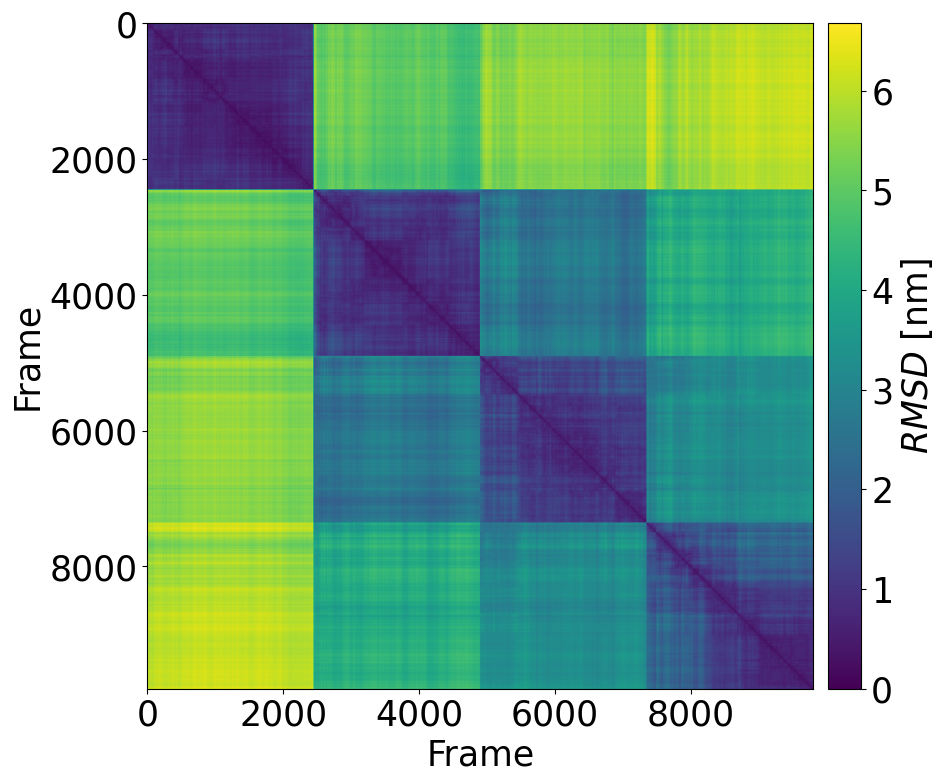

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(1,1, figsize = (10,10))
#axes = axes.flatten()

#im1 = axes.imshow(sym_prmsd_jax_nm[0:2000,0:2000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[2000:4000,2000:4000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[4000:6000,4000:6000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[6000:8000,6000:8000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[8000:11000,8000:11000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[11000:14000,11000:14000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[8000:14000,8000:14000], cmap='viridis', vmin=0)
#axes.scatter(4274, 723, s=50, c='yellow')

im1 = axes.imshow(sym_prmsd_jax_nm, cmap='viridis', vmin=0)


axes.set_xlabel('Frame')
axes.set_ylabel('Frame')


#axes.set_xticks(ticks=list(np.arange(0,12000, 3000)), labels=list(np.arange(0,12000, 3000)))
#axes.set_yticks(ticks=list(np.arange(0,12000, 3000)), labels=list(np.arange(0,12000, 3000)))

divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im1, cax=cax, orientation='vertical', label='$RMSD$ [nm]')


fig.tight_layout()    
#fig.savefig('jax-rmsd-integrin-skip1500.png',dpi=150)

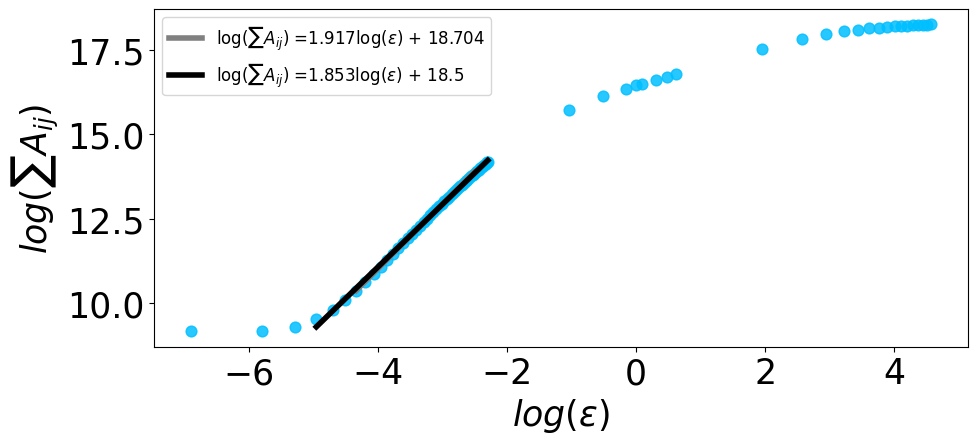

In [37]:
#### generate a range of epsilon

epsilon = jnp.concatenate(( jnp.arange(0.001,0.1,.002), jnp.arange(0.1,2,.25), jnp.arange(1,100,6) ))

#print(epsilon)

sum_A = []
for e in epsilon:
    #A = jnp.exp(-jnp.square(sym_prmsd_jax_nm[:2000,:2000])/(2*e))
    A = jnp.exp(-jnp.square(sym_prmsd_jax_nm)/(2*e))
    
    sum_A.append(A.sum())
    
    
    
fig, axes = plt.subplots(1, 1, figsize = (10,5))

plt.scatter(np.log(epsilon), np.log(sum_A), alpha=0.85, color='deepskyblue',s=60)

#plt.yscale('log')
#plt.xscale('log')

#plt.ylim(0,1e5)
plt.xlabel(r'$log(\epsilon)$') #[nm$^{2}$]
plt.ylabel(r'$log(\sum A_{ij})$')


def linear_fit(x, a, b):
    return a*x + b

from scipy.optimize import curve_fit

### case 1
e2_1 = np.log(epsilon)[np.log(epsilon)>-4.5]
a2_1 = np.log(sum_A)[np.log(epsilon)>-4.5]
a2_1 = a2_1[e2_1<-2]
e2_1 = e2_1[e2_1<-2]

### case 2
e2_2 = np.log(epsilon)[np.log(epsilon)>-4.5]
a2_2 = np.log(sum_A)[np.log(epsilon)>-4.5]
a2_2 = a2_2[e2_2<-2.5]
e2_2 = e2_2[e2_2<-2.5]

### case 3
e2_3 = np.log(epsilon)[np.log(epsilon)>-5.]
a2_3 = np.log(sum_A)[np.log(epsilon)>-5.]
a2_3 = a2_3[e2_3<-2]
e2_3 = e2_3[e2_3<-2]

popt_1, _ = curve_fit(linear_fit, e2_1, a2_1, p0=(1,0))
popt_2, _ = curve_fit(linear_fit, e2_2, a2_2, p0=(1,0))
popt_3, _ = curve_fit(linear_fit, e2_3, a2_3, p0=(1,0))


#plt.plot(e2_1, linear_fit(e2_1, popt_1[0], popt_1[1]), color="gray", lw=4, label='log($\sum A_{ij}$) ='+str(round(popt_1[0],3))+'log($\epsilon$) + '+str(round(popt_1[1],3)))
plt.plot(e2_2, linear_fit(e2_2, popt_2[0], popt_2[1]), color="gray", lw=4, label='log($\sum A_{ij}$) ='+str(round(popt_2[0],3))+'log($\epsilon$) + '+str(round(popt_2[1],3)))
plt.plot(e2_3, linear_fit(e2_3, popt_3[0], popt_3[1]), color="black", lw=4, label='log($\sum A_{ij}$) ='+str(round(popt_3[0],3))+'log($\epsilon$) + '+str(round(popt_3[1],3)))

#scipy.optimize.curve_fit(func, x, y)

plt.legend(fontsize=12)


#plt.title(r'ref frame: {0}'.format(ref_i), fontsize=32)

fig.tight_layout()
fig.savefig('epsilon-integrin-A-skip100.png',dpi=150)


In [14]:
np.log(np.exp(0.5)+4) - np.log(np.exp(0.4))
np.log(1.3314291957733713)
np.exp(4)
np.log(54.598150033144236)
np.log(4)
np.round(np.log(np.exp(1.3862943611198906)),2)

1.39

In [2]:
import numpy as np
print(np.exp(.5), np.exp(4))


1.6487212707001282 54.598150033144236


In [11]:
#lamb_e = []
#eps_e = []
#for e in list(np.arange(np.exp(-4.5), np.exp(log_selected_e), 0.2)):
#    
#    print(e)
#    eps_e.append(e)
#    _lamb_e, _ = dMap_jax.diffMaps(e, sym_prmsd_jax_nm, jit_compile=True, tol=-1e-7)
#    lamb_e.append(_lamb_e)


## grid search of epsilon and alpha
epsilon_min = np.exp(.5)
epsilon_max = np.exp(4)
epsilon_step = 4

alpha_min = 0
alpha_max = 1.1 #0.1
alpha_step = 0.1 #0.01

%env XLA_PYTHON_CLIENT_PREALLOCATE=False

_lamb = []
_psi = []
_ea = []
for i in np.arange(epsilon_min + 12*epsilon_step, epsilon_max, epsilon_step):
#for i in [np.exp(3.982)]:
#for i in [epsilon_min + 11* epsilon_step]:
    for j in np.arange(alpha_min, alpha_max, alpha_step):
    #for j in np.arange(0.8, alpha_max-0.01, alpha_step):
        #print(i, j)
        __lamb, __psi = dMap_jax.diffMaps(i, sym_prmsd_jax_nm, alpha=j,
                                      jit_compile=True, check_pos_definite=True, tol=-1e-3)
        _lamb.append(__lamb)
        _psi.append(__psi)
        _ea.append([i,j])


#start = time.time()
#print("eps is set to {0}".format(selected_e))
#lamb, psi = dMap_jax.diffMaps(selected_e, sym_prmsd_jax_nm, alpha=0.05,
#                               jit_compile=True, check_pos_definite=True, tol=-1e-4)
#print("JAX dMap calculations finished in {} seconds".format(time.time()-start)) 

#start = time.time()
#lamb_np, psi_np = dMap_jax.diffMaps_Numpy(selected_e, sym_prmsd_jax_nm, alpha=0.5)
#print("Numpy dMap calculations finished in {} seconds".format(time.time()-start)) 


env: XLA_PYTHON_CLIENT_PREALLOCATE=False
0.0
Applying adaptive density diffusion map using alpha:0.0
0.1
Applying adaptive density diffusion map using alpha:0.1
0.2
Applying adaptive density diffusion map using alpha:0.2
0.30000000000000004
Applying adaptive density diffusion map using alpha:0.30000000000000004
0.4
Applying adaptive density diffusion map using alpha:0.4
0.5
Applying adaptive density diffusion map using alpha:0.5
0.6000000000000001
Applying adaptive density diffusion map using alpha:0.6000000000000001
0.7000000000000001
Applying adaptive density diffusion map using alpha:0.7000000000000001
0.8
Applying adaptive density diffusion map using alpha:0.8
0.9
Applying adaptive density diffusion map using alpha:0.9
1.0
Applying adaptive density diffusion map using alpha:1.0
0.0
Applying adaptive density diffusion map using alpha:0.0
0.1
Applying adaptive density diffusion map using alpha:0.1
0.2
Applying adaptive density diffusion map using alpha:0.2
0.30000000000000004
Applyin

In [15]:
#_psi#.shape

In [13]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=False
with open("integrin_cg_aa_300_grid_search_e_alpha_4.pkl", "wb") as f:
    #pickle.dump({'_lamb': __lamb, '_psi': __psi, '_ea': __ea}, f)
    pickle.dump({'_lamb': _lamb, '_psi': _psi, '_ea': _ea}, f)
      

env: XLA_PYTHON_CLIENT_PREALLOCATE=False


In [12]:
_ea

[[49.64872127070013, 0.0],
 [49.64872127070013, 0.1],
 [49.64872127070013, 0.2],
 [49.64872127070013, 0.30000000000000004],
 [49.64872127070013, 0.4],
 [49.64872127070013, 0.5],
 [49.64872127070013, 0.6000000000000001],
 [49.64872127070013, 0.7000000000000001],
 [49.64872127070013, 0.8],
 [49.64872127070013, 0.9],
 [49.64872127070013, 1.0],
 [53.64872127070013, 0.0],
 [53.64872127070013, 0.1],
 [53.64872127070013, 0.2],
 [53.64872127070013, 0.30000000000000004],
 [53.64872127070013, 0.4],
 [53.64872127070013, 0.5],
 [53.64872127070013, 0.6000000000000001],
 [53.64872127070013, 0.7000000000000001],
 [53.64872127070013, 0.8],
 [53.64872127070013, 0.9],
 [53.64872127070013, 1.0]]

In [16]:
#_lamb = np.array(_lamb)
#_psi = np.array(_psi)
#_ea = np.array(_ea)
#
with open("integrin_cg_aa_300_grid_search_e_alpha_3.pkl", "rb") as f:
    data = pickle.load(f)
    
__lamb = np.concatenate((data['_lamb'], _lamb))
__psi = np.concatenate((data['_psi'], _psi))
__ea = np.concatenate((data['_ea'], _ea))

##_lamb = data['_lamb']
##_psi = data['_psi']
##_ea = data['_ea']
##
      

In [14]:
import pickle
#with open("integrin_cg_aa_300_grid_search/integrin_cg_aa_300_grid_search_e_alpha_1.pkl", "rb") as f:
#    data = pickle.load(f)
#    
#
#_lamb = data['_lamb']
#_psi = data['_psi']
#_ea = data['_ea']
#

In [51]:
#with open("integrin_cg_aa_300_grid_search/integrin_cg_aa_300_grid_search_e_alpha_0.pkl", "rb") as f:
#    data = pickle.load(f)
    
#with open("integrin_cg_aa_300_grid_search/integrin_cg_aa_300_grid_search_e_alpha_1.pkl", "rb") as f:
#    data = pickle.load(f)
    
#with open("integrin_cg_aa_300_grid_search/integrin_cg_aa_300_grid_search_e_alpha_2.pkl", "rb") as f:
#    data = pickle.load(f)

#with open("integrin_cg_aa_300_grid_search/integrin_cg_aa_300_grid_search_e_alpha_3.pkl", "rb") as f:
#    data = pickle.load(f)
    
#with open("integrin_cg_aa_300_grid_search/integrin_cg_aa_300_grid_search_e_alpha_4.pkl", "rb") as f:
#    data = pickle.load(f)

with open("integrin_cg_aa_300_grid_search/integrin_cg_aa_300_grid_search_e_alpha_0.1_max.pkl", "rb") as f:
    data = pickle.load(f)

    
_lamb = np.array(data['_lamb'])
_psi = np.array(data['_psi'])
_ea = np.array(data['_ea'])


In [52]:
_ea.shape

(10, 2)

nplots_x:2, nplots_y:5
nplots_x:2, nplots_y:5


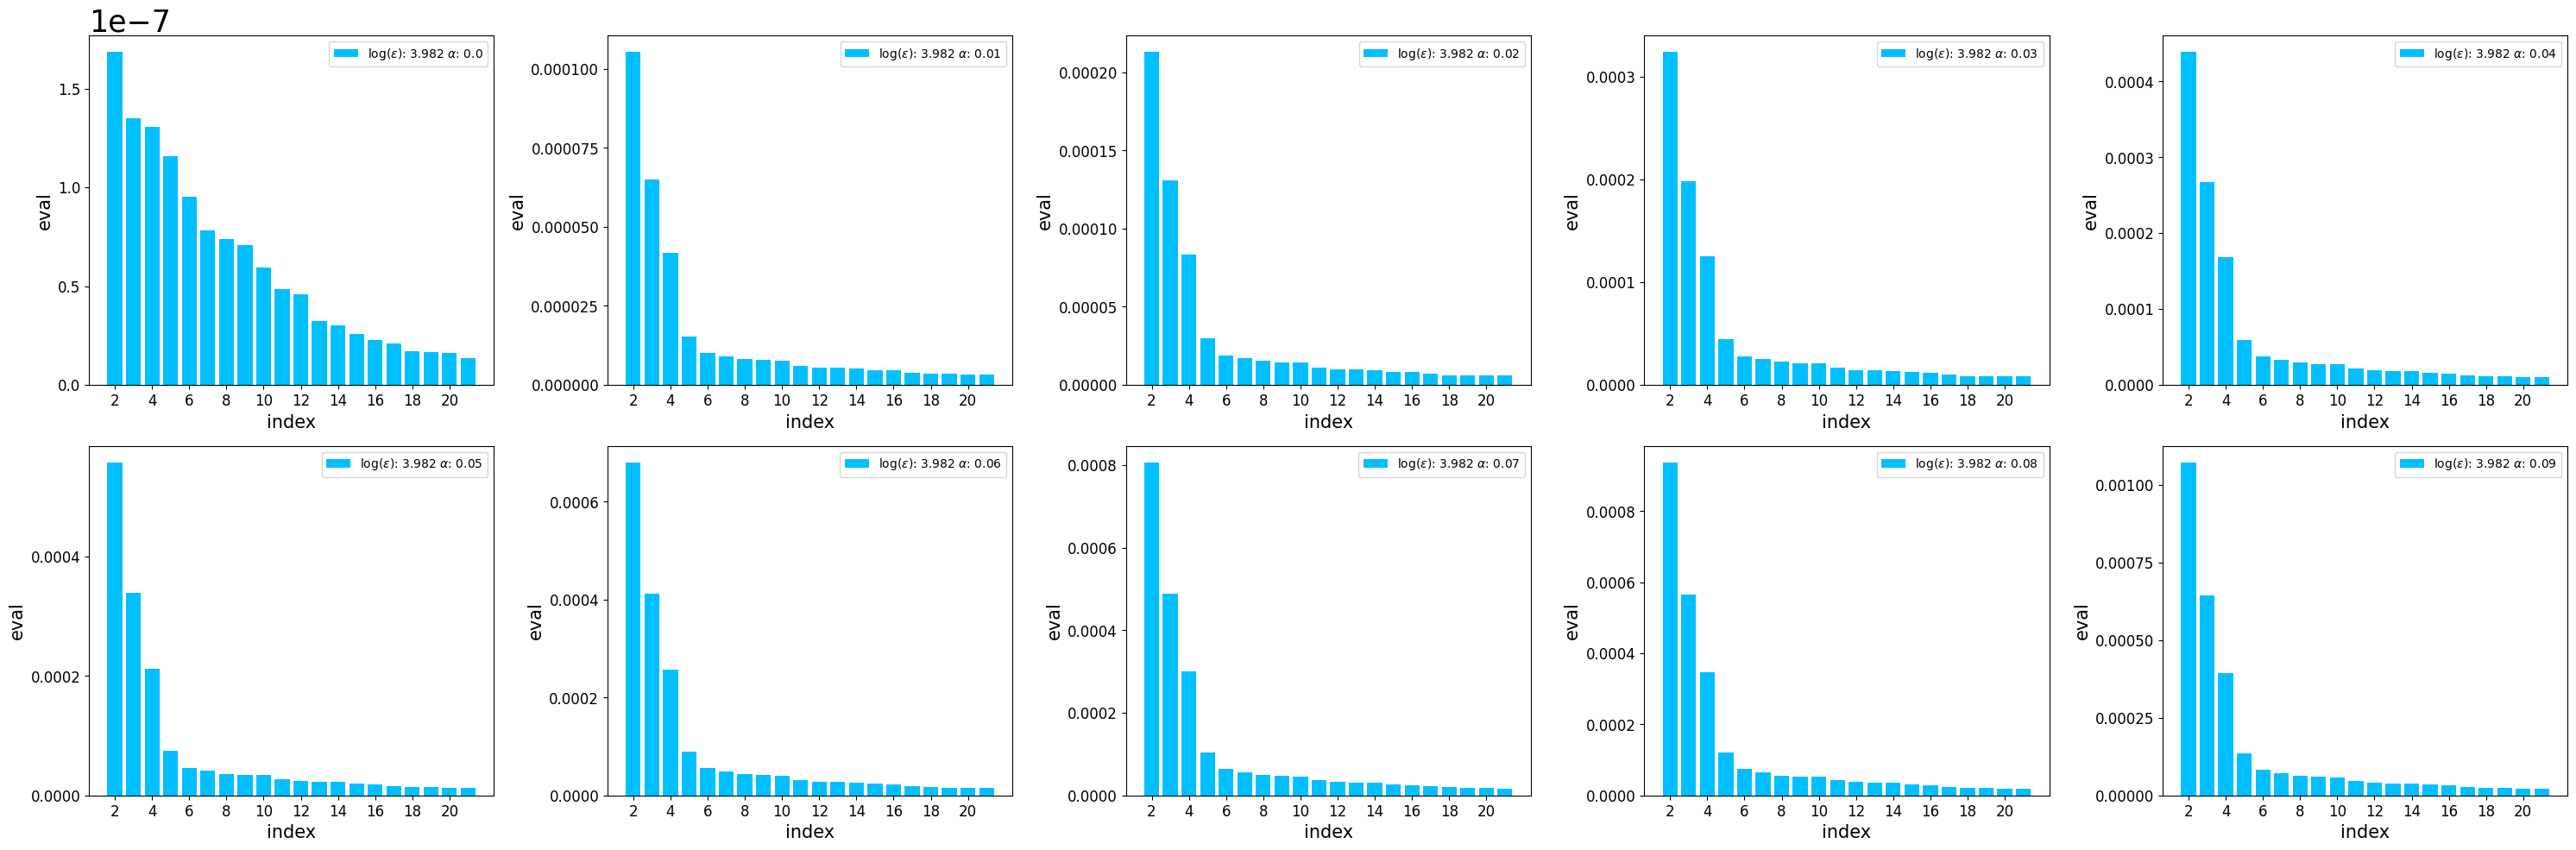

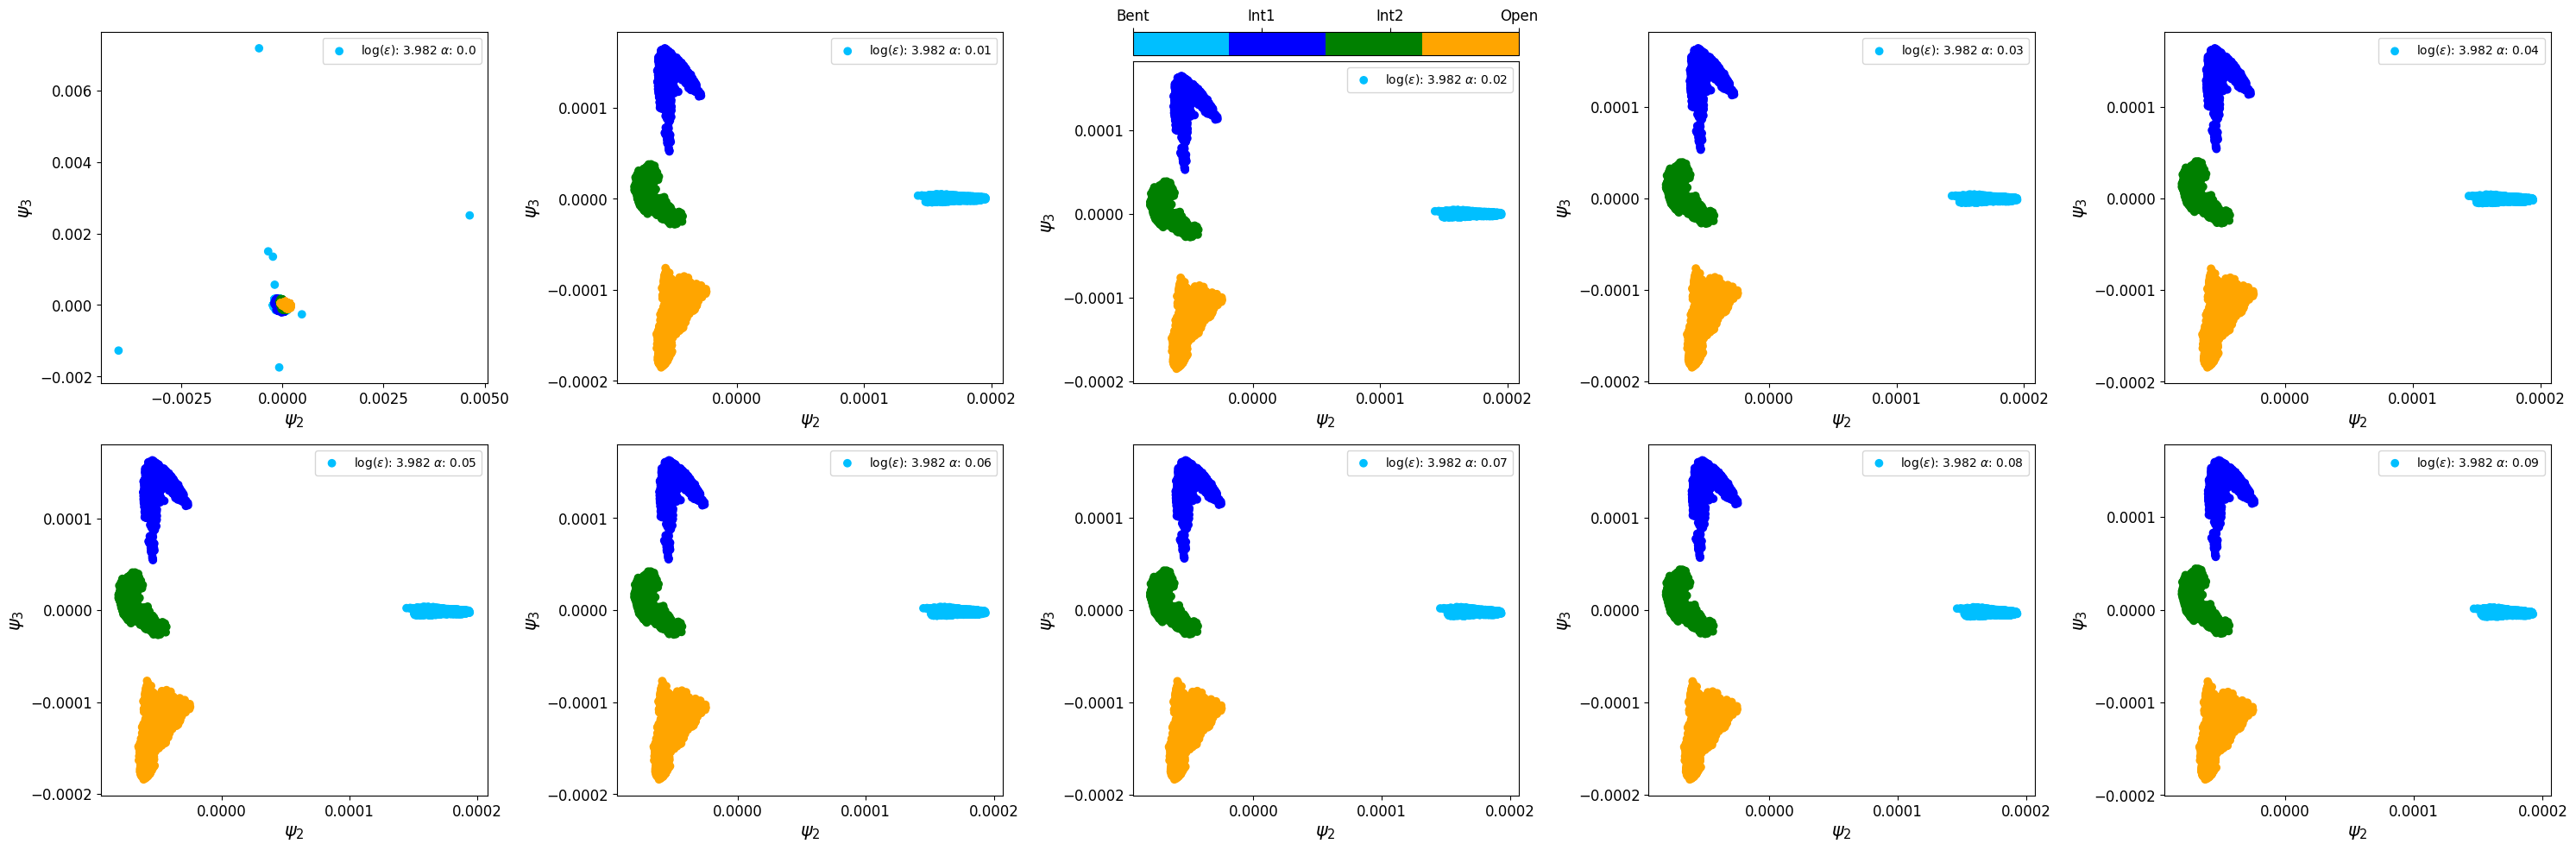

In [55]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot2Dmaps(data, title, nplots_x, nplots_y, dtype, nvecs, lead, colorMap, cmap, colorlabel, count_max, figSuffix=''):
    
    
    print(f"nplots_x:{nplots_x}, nplots_y:{nplots_y}")
    
    if dtype == 'spec':
        fig = plt.figure(figsize = (30,10)) #(30,20))
    else:
        fig = plt.figure(figsize = (30,10)) #(30,20))
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.4)
    
    count = 0
    for i in range(nplots_x):
        for j in range(nplots_y):
            
            if count > count_max:
                continue
    
            ax = fig.add_subplot(nplots_x,nplots_y,count+1)
        
            label = r'log($\epsilon$): ' + str(np.round(np.log(title[count][0]),3)) + r' $\alpha$: ' + str(np.round(title[count][1],3))
            
            if dtype == 'spec':
                #ax.bar(np.arange(len(data[count][-20:])), data[count][-20:], color=colorMap,label=label)
                ax.bar(np.arange(len(data[count][lead:nvecs])), data[count][lead:nvecs], color=colorMap,
                      label=label)
                ax.set_xlabel('index', fontsize=15)
                ax.set_ylabel('eval', fontsize=15)
                #plt.xticks(np.arange(-20, -1, step=2), 
                #           list(np.arange(-20, -1, step=2)), fontsize=12)
                plt.xticks(np.arange(lead-1, len(data[count][1:nvecs]), step=2), 
                           list(np.arange(lead+1, len(data[count][1:nvecs])+1, step=2)), fontsize=12)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                
            else:
                im = ax.scatter(data[count][:,lead], data[count][:,lead+1], c=colorMap, cmap=cmap, label=label)
                ax.set_xlabel('$\psi$$_{'+str(lead+1)+'}$', fontsize=15)
                ax.set_ylabel('$\psi$$_{'+str(lead+2)+'}$', fontsize=15)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                if count == 2:
                    
                    divider = make_axes_locatable(ax)
                    cax = divider.append_axes("top", size="7%", pad="2%") #new_vertical("top", pad='5%')
                    fig.add_axes(cax)
                    cbar = fig.colorbar(im, cax=cax, orientation="horizontal",
                                        ticks=list(np.arange(1,len(colorlabel)+1)))
                    cbar.set_ticklabels(colorlabel, fontsize=12)
                    cax.xaxis.set_ticks_position("top")
                
            ax.legend(fontsize=10)
            fig.tight_layout(pad=.5)
            fig.savefig(figSuffix, dpi=100)

            count += 1
    return

figname_offset=99 + 33 + 22
select_grid_start = 0
select_grid_end = 33 #10 #20
rows_plot = 2 #4 #9
cols_plot = 5
lead=1
nvecs=20
count_max=21

#plot2Dmaps(_lamb[select_grid_start:select_grid_end], _ea[select_grid_start:select_grid_end], rows_plot, cols_plot, 'spec', nvecs=nvecs+lead, 
#           lead=lead, colorMap='deepskyblue', cmap='Accent', colorlabel='None', count_max=count_max,
#           figSuffix='trail_evals_leading_' +str(nvecs) + '_startgrid_' + str(select_grid_start+figname_offset) + '_end_grid' + str(select_grid_end+figname_offset) + '.png' )
#

plot2Dmaps(_lamb[select_grid_start:select_grid_end], _ea[select_grid_start:select_grid_end], rows_plot, cols_plot, 'spec', nvecs=nvecs+lead, 
           lead=lead, colorMap='deepskyblue', cmap='Accent', colorlabel='None', count_max=count_max,
           figSuffix='evals_leading_' +str(nvecs) + '_startgrid_' + str(select_grid_start+figname_offset) + '_end_grid' + str(select_grid_end+figname_offset) + '.png' )

lcmap = (mpl.colors.ListedColormap(['deepskyblue', 'blue', 'green', 'orange']) #'red', 'black'
        .with_extremes(over='0.25', under='0.75'))
colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3, np.ones(2450)*4]
plot2Dmaps(_psi[select_grid_start:select_grid_end], _ea[select_grid_start:select_grid_end], rows_plot, cols_plot, '', nvecs=nvecs+lead, 
           lead=lead, colorMap=colors, cmap=lcmap, colorlabel=['Bent', 'Int1', 'Int2', 'Open'], count_max=count_max,
           figSuffix='evecs_leading_' +str(nvecs) + '_startgrid_' + str(select_grid_start+figname_offset) + '_end_grid' + str(select_grid_end+figname_offset) + '.png' )


In [256]:
_ea = [np.array([16.4872127, 1      ])] #_ea[0] 

In [265]:
#colors = [np.arange(nframes)*1, np.arange(nframes, 2*nframes)*1, np.arange(nframes*2, 3*nframes)*1, np.arange(nframes*3, 4*nframes)*1]
#colors = list(np.concatenate((colors[0], colors[1], colors[3], colors[3])))
#colors = colors[0:]
#
#lcmap = (mpl.colors.ListedColormap(['deepskyblue', 'blue', 'green', 'orange']) #'red', 'black'
#        .with_extremes(over='0.25', under='0.75'))
#
#diff_plots.plotmaps(__psi[0], '0', plot_stride=1, select_axis_2d=[0, 1], skip_lead=True, colorMap=colors, cmap=lcmap, colorbar=True, colorlabel='Model', skip_3D=False, figSuffix = 'colorbymodel_opt1')
#

In [25]:
np.exp(3.982)

53.62417540140635

In [11]:
_ea = [np.array([np.exp(3.982), 0.0 ])] #_ea[0] 

In [12]:
x0=sym_prmsd_jax_nm
b0 = jnp.exp((-(x0/1)**(2*_ea[0][1]))/(2*_ea[0][0]))

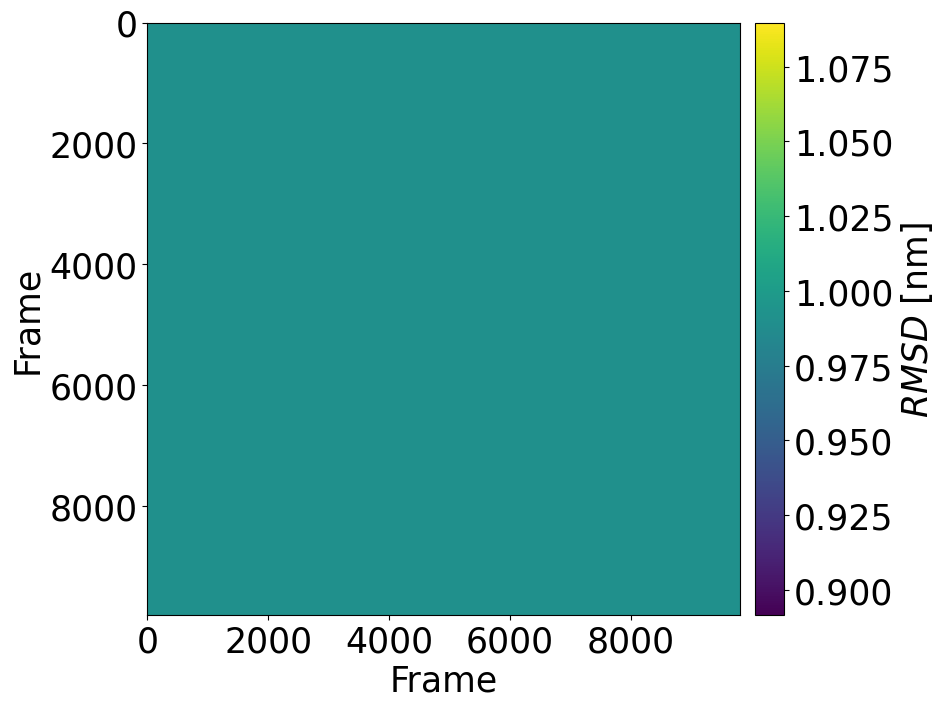

In [48]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(1,1, figsize = (10,10))
#axes = axes.flatten()

#im1 = axes.imshow(sym_prmsd_jax_nm[0:2000,0:2000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[2000:4000,2000:4000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[4000:6000,4000:6000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[6000:8000,6000:8000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[8000:11000,8000:11000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[11000:14000,11000:14000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[8000:14000,8000:14000], cmap='viridis', vmin=0)
#axes.scatter(4274, 723, s=50, c='yellow')

im1 = axes.imshow(b0, cmap='viridis')#, vmin=0.8)


axes.set_xlabel('Frame')
axes.set_ylabel('Frame')


#axes.set_xticks(ticks=list(np.arange(0,12000, 3000)), labels=list(np.arange(0,12000, 3000)))
#axes.set_yticks(ticks=list(np.arange(0,12000, 3000)), labels=list(np.arange(0,12000, 3000)))

divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im1, cax=cax, orientation='vertical', label='$RMSD$ [nm]')


fig.tight_layout()    
fig.savefig('jax-rmsd-integrin-kernel_e_alpha' + str(_ea[0][0]) + '_' + str(_ea[0][1]) + '.png',dpi=150)

In [49]:

start = time.time()
#sym_prmsd_jax_nm[:2450*2,:2450*2]
__lamb, __psi = dMap_jax.diffMaps(_ea[0][0], x0, alpha=_ea[0][1],
                               jit_compile=True, check_pos_definite=True, tol=-1e-2)
print("JAX dMap calculations finished in {} seconds".format(time.time()-start)) 


0.0
Applying adaptive density diffusion map using alpha:0.0
JAX dMap calculations finished in 3.3979640007019043 seconds


In [50]:
__psi[0]#.shape

Array([ 1.02517646e-04, -2.65238195e-05, -5.34769197e-06, ...,
        0.00000000e+00,  3.74417664e-06, -6.08848813e-06], dtype=float32)

nplots_x:1, nplots_y:1


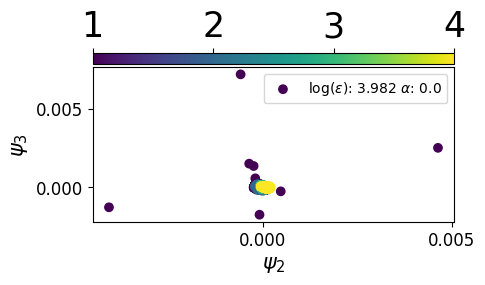

In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

__psi=[__psi]

def plot2Dmaps(data, title, nplots_x, nplots_y, dtype, nvecs, lead, colorMap, cmap, colorlabel, figSuffix=''):
    
    
    print(f"nplots_x:{nplots_x}, nplots_y:{nplots_y}")
    
    if dtype == 'spec':
        fig = plt.figure(figsize = (20,20))
    else:
        fig = plt.figure(figsize = (5,3))
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.4)
    
    count = 0
    for i in range(nplots_x):
        for j in range(nplots_y):
    
            ax = fig.add_subplot(nplots_x,nplots_y,count+1)
        
            label = r'log($\epsilon$): ' + str(np.round(np.log(title[count][0]),3)) + r' $\alpha$: ' + str(np.round(title[count][1],3))
            
            if dtype == 'spec':
                ax.bar(np.arange(len(data[count][lead:nvecs])), data[count][lead:nvecs], color=colorMap,
                      label=label)
                ax.set_xlabel('index', fontsize=15)
                ax.set_ylabel('eval', fontsize=15)
                plt.xticks(np.arange(lead-1, len(data[count][1:nvecs]), step=2), 
                           list(np.arange(lead+1, len(data[count][1:nvecs])+1, step=2)), fontsize=12)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                
            else:
                im = ax.scatter(data[count][0:,lead], data[count][0:,lead+1], c=colorMap, cmap=cmap, label=label)
                ax.set_xlabel('$\psi$$_{'+str(lead+1)+'}$', fontsize=15)
                ax.set_ylabel('$\psi$$_{'+str(lead+2)+'}$', fontsize=15)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                if count == 0:
                    
                    divider = make_axes_locatable(ax)
                    cax = divider.append_axes("top", size="7%", pad="2%") #new_vertical("top", pad='5%')
                    fig.add_axes(cax)
                    cbar = fig.colorbar(im, cax=cax, orientation="horizontal",
                                        ticks=list(np.arange(1,len(colorlabel)+1)))
                    #cbar.set_ticklabels(colorlabel, fontsize=12)
                    cax.xaxis.set_ticks_position("top")
                
            ax.legend(fontsize=10)
            fig.tight_layout(pad=.5)
            fig.savefig(figSuffix, dpi=100)

            count += 1
    return

figname_offset=0
select_grid_start = 0
select_grid_end = 1
rows_plot = 1 #9
cols_plot = 1
lead=1
nvecs=20


#lcmap = (mpl.colors.ListedColormap(['deepskyblue', 'blue', 'green', 'orange']) #'red', 'black'
#        .with_extremes(over='0.25', under='0.75'))
lcmap = 'viridis'

colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3, np.ones(2450)*4]
nframes = 9800/4
#colors = [np.arange(nframes)*1, np.arange(nframes, 2*nframes)*1, np.arange(nframes*2, 3*nframes)*1, np.arange(nframes*3, 4*nframes)*1]
#colors = list(np.concatenate((colors[0], colors[1], colors[3], colors[3])))
colors = colors[0:]
plot2Dmaps(__psi[select_grid_start:select_grid_end], _ea[select_grid_start:select_grid_end], rows_plot, cols_plot, '', nvecs=nvecs+lead, 
           lead=lead, colorMap=colors, cmap=lcmap, colorlabel=['Bent', 'Int1', 'Int2', 'Open'],
           figSuffix='dmaps_leading_e_alpha' + str(_ea[0][0]) + '_' + str(_ea[0][1]) + '.png' )


In [11]:
k=np.ones(sym_prmsd_jax_nm.shape)

#k[0:2450,0:2450] = np.ones([2450,2450])*(sym_prmsd_jax_nm[0:2450,0:2450]**2) #np.max(sym_prmsd_jax_nm[0:2450,0:2450])*(20/20)
#k[0:2450,2450:2450*2] = np.ones([2450,2450])*(sym_prmsd_jax_nm[0:2450,2450:2450*2]**2)*2 #np.max(sym_prmsd_jax_nm[0:2450,2450:2450*2])*(15/15)
#k[0:2450,2450*2:2450*3] = np.ones([2450,2450])*(sym_prmsd_jax_nm[0:2450,2450*2:2450*3]**2)*2 #np.max(sym_prmsd_jax_nm[0:2450,2450*2:2450*3])*(15/15)
#k[0:2450,2450*3:2450*4] = np.ones([2450,2450])*(sym_prmsd_jax_nm[0:2450,2450*3:2450*4]**2)*2 #np.max(sym_prmsd_jax_nm[0:2450,2450*3:2450*4])*(15/15)
#
#k[2450:2450*2,0:2450] = np.ones([2450,2450])*(sym_prmsd_jax_nm[2450:2450*2,0:2450]**2)*2 #np.max(sym_prmsd_jax_nm[2450:2450*2,0:2450])*(15/15)
#k[2450:2450*2,2450:2450*2] = np.ones([2450,2450])*sym_prmsd_jax_nm[2450:2450*2,2450:2450*2]**2  #np.max(sym_prmsd_jax_nm[2450:2450*2,2450:2450*2])*(20/20)
#k[2450:2450*2,2450*2:2450*3] = np.ones([2450,2450])*(sym_prmsd_jax_nm[2450:2450*2,2450*2:2450*3]**2)*2 #np.max(sym_prmsd_jax_nm[2450:2450*2,2450*2:2450*3])*(15/15)
#k[2450:2450*2,2450*3:2450*4] = np.ones([2450,2450])*(sym_prmsd_jax_nm[2450:2450*2,2450*3:2450*4]**2)*2 #np.max(sym_prmsd_jax_nm[2450:2450*2,2450*3:2450*4])*(15/15)
#
#k[2450*2:2450*3,0:2450] = np.ones([2450,2450])*(sym_prmsd_jax_nm[2450*2:2450*3,0:2450]**2)*2 #np.max(sym_prmsd_jax_nm[2450*2:2450*3,0:2450])*(15/15)
#k[2450*2:2450*3,2450:2450*2] = np.ones([2450,2450])*(sym_prmsd_jax_nm[2450*2:2450*3,2450:2450*2]**2)*2 #np.max(sym_prmsd_jax_nm[2450*2:2450*3,2450:2450*2])*(15/15)
#k[2450*2:2450*3,2450*2:2450*3] = np.ones([2450,2450])*sym_prmsd_jax_nm[2450*2:2450*3,2450*2:2450*3]**2  #np.max(sym_prmsd_jax_nm[2450*2:2450*3,2450*2:2450*3])*(20/20)
#k[2450*2:2450*3,2450*3:2450*4] = np.ones([2450,2450])*(sym_prmsd_jax_nm[2450*2:2450*3,2450*3:2450*4]**2)*2 #np.max(sym_prmsd_jax_nm[2450*2:2450*3,2450*3:2450*4])*(15/15)
#
#k[2450*3:2450*4,0:2450] = np.ones([2450,2450])*(sym_prmsd_jax_nm[2450*3:2450*4,0:2450]**2)*2 #np.max(sym_prmsd_jax_nm[2450*3:2450*4,0:2450])*(15/15)
#k[2450*3:2450*4,2450:2450*2] = np.ones([2450,2450])*(sym_prmsd_jax_nm[2450*3:2450*4,2450:2450*2]**2)*2 #np.max(sym_prmsd_jax_nm[2450*3:2450*4,2450:2450*2])*(15/15)
#k[2450*3:2450*4,2450*2:2450*3] = np.ones([2450,2450])*(sym_prmsd_jax_nm[2450*3:2450*4,2450*2:2450*3]**2)*2 #np.max(sym_prmsd_jax_nm[2450*3:2450*4,2450*2:2450*3])*(15/15)
#k[2450*3:2450*4,2450*3:2450*4] = np.ones([2450,2450])*sym_prmsd_jax_nm[2450*3:2450*4,2450*3:2450*4]**2  #np.max(sym_prmsd_jax_nm[2450*3:2450*4,2450*3:2450*4])*(20/20)

k[0:2450,0:2450] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[0:2450,0:2450])
k[0:2450,2450:2450*2] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[0:2450,2450:2450*2])
k[0:2450,2450*2:2450*3] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[0:2450,2450*2:2450*3])
k[0:2450,2450*3:2450*4] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[0:2450,2450*3:2450*4])

k[2450:2450*2,0:2450] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450:2450*2,0:2450])
k[2450:2450*2,2450:2450*2] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450:2450*2,2450:2450*2])
k[2450:2450*2,2450*2:2450*3] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450:2450*2,2450*2:2450*3])
k[2450:2450*2,2450*3:2450*4] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450:2450*2,2450*3:2450*4])

k[2450*2:2450*3,0:2450] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450*2:2450*3,0:2450])
k[2450*2:2450*3,2450:2450*2] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450*2:2450*3,2450:2450*2])
k[2450*2:2450*3,2450*2:2450*3] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450*2:2450*3,2450*2:2450*3])
k[2450*2:2450*3,2450*3:2450*4] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450*2:2450*3,2450*3:2450*4])

k[2450*3:2450*4,0:2450] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450*3:2450*4,0:2450])
k[2450*3:2450*4,2450:2450*2] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450*3:2450*4,2450:2450*2])
k[2450*3:2450*4,2450*2:2450*3] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450*3:2450*4,2450*2:2450*3])
k[2450*3:2450*4,2450*3:2450*4] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450*3:2450*4,2450*3:2450*4])

#k = k*10
#k[np.diag_indices(k.shape[0])] = 1


#k[2450:2450*2,0:2450] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450:2450*2,0:2450])
#k[2450:2450*2,2450:2450*2] = np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450:2450*2,2450:2450*2])

#np.concatenate((np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[:2450*1,:2450*1]),
#                  np.ones([2450,2450])*np.max(sym_prmsd_jax_nm[2450:2,:2450*1]) ))
k

array([[1.58673978, 1.58673978, 1.58673978, ..., 6.67948627, 6.67948627,
        6.67948627],
       [1.58673978, 1.58673978, 1.58673978, ..., 6.67948627, 6.67948627,
        6.67948627],
       [1.58673978, 1.58673978, 1.58673978, ..., 6.67948627, 6.67948627,
        6.67948627],
       ...,
       [6.67948627, 6.67948627, 6.67948627, ..., 3.17011523, 3.17011523,
        3.17011523],
       [6.67948627, 6.67948627, 6.67948627, ..., 3.17011523, 3.17011523,
        3.17011523],
       [6.67948627, 6.67948627, 6.67948627, ..., 3.17011523, 3.17011523,
        3.17011523]])

In [32]:
_ea = [np.array([k, 0.25 ])] #_ea[0] 

/tmp/ipykernel_25636/2482875082.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _ea = [np.array([k, 0.25 ])] #_ea[0]


In [33]:
sym_prmsd_jax_nm**2

Array([[0.00000000e+00, 1.09460443e-01, 1.17914245e-01, ...,
        3.77566643e+01, 3.81153336e+01, 3.78824081e+01],
       [1.09460443e-01, 0.00000000e+00, 3.79395224e-02, ...,
        3.90818748e+01, 3.94754219e+01, 3.92368240e+01],
       [1.17914245e-01, 3.79395224e-02, 0.00000000e+00, ...,
        3.89856415e+01, 3.93861008e+01, 3.91435432e+01],
       ...,
       [3.77566643e+01, 3.90818748e+01, 3.89856415e+01, ...,
        0.00000000e+00, 7.06388503e-02, 4.20461036e-02],
       [3.81153336e+01, 3.94754219e+01, 3.93861008e+01, ...,
        7.06388503e-02, 0.00000000e+00, 3.59705798e-02],
       [3.78824081e+01, 3.92368240e+01, 3.91435432e+01, ...,
        4.20461036e-02, 3.59705798e-02, 0.00000000e+00]], dtype=float32)

In [34]:
x0=sym_prmsd_jax_nm
b = jnp.exp((-(x0/1)**(2*_ea[0][1]))/(2*_ea[0][0]))
#b = x0/k # 
b

Array([[1.        , 0.8342266 , 0.83139294, ..., 0.8306422 , 0.8302775 ,
        0.830514  ],
       [0.8342266 , 1.        , 0.8701661 , ..., 0.8293083 , 0.8289191 ,
        0.8291547 ],
       [0.83139294, 0.8701661 , 1.        , ..., 0.82940394, 0.82900715,
        0.8292471 ],
       ...,
       [0.8306422 , 0.8293083 , 0.82940394, ..., 1.        , 0.9219058 ,
        0.93106973],
       [0.8302775 , 0.8289191 , 0.82900715, ..., 0.9219058 , 1.        ,
        0.9336178 ],
       [0.830514  , 0.8291547 , 0.8292471 , ..., 0.93106973, 0.9336178 ,
        1.        ]], dtype=float32)

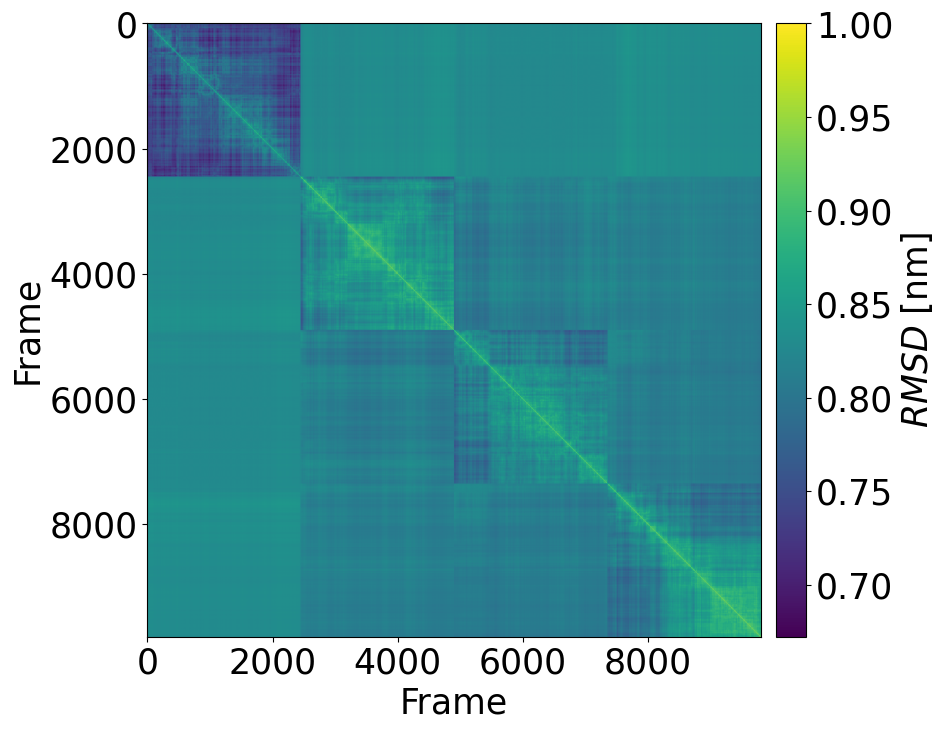

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(1,1, figsize = (10,10))
#axes = axes.flatten()

#im1 = axes.imshow(sym_prmsd_jax_nm[0:2000,0:2000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[2000:4000,2000:4000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[4000:6000,4000:6000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[6000:8000,6000:8000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[8000:11000,8000:11000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[11000:14000,11000:14000], cmap='viridis', vmin=0)
#im1 = axes.imshow(sym_prmsd_jax_nm[8000:14000,8000:14000], cmap='viridis', vmin=0)
#axes.scatter(4274, 723, s=50, c='yellow')

im1 = axes.imshow(b, cmap='viridis')#, vmin=0.8)

axes.set_xlabel('Frame')
axes.set_ylabel('Frame')

#axes.set_xticks(ticks=list(np.arange(0,12000, 3000)), labels=list(np.arange(0,12000, 3000)))
#axes.set_yticks(ticks=list(np.arange(0,12000, 3000)), labels=list(np.arange(0,12000, 3000)))

divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im1, cax=cax, orientation='vertical', label='$RMSD$ [nm]')

fig.tight_layout()    
#fig.savefig('jax-rmsd-integrin-kernel_e_alpha' + 'k_norm' + '_' + str(_ea[0][1]) + '.png',dpi=150)

<BarContainer object of 20 artists>

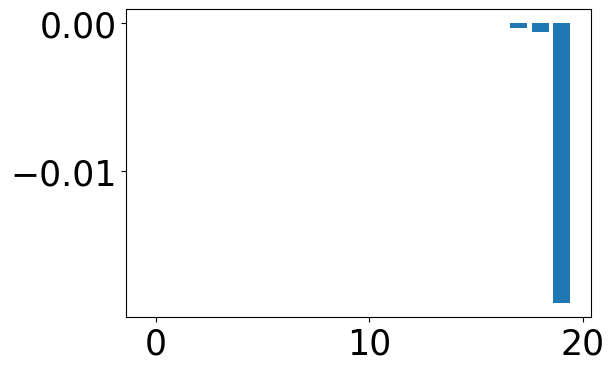

In [39]:
fig = plt.figure(figsize = (6,4))
    
#plt.subplots_adjust(left=0.1,
#                bottom=0.1,
#                right=0.9,
#                top=0.9,
#                wspace=0.5,
#                hspace=0.4)
#
ax = fig.add_subplot(1,1,1)
ax.bar(np.arange(len(__lamb[-20:])), __lamb[-20:])
#ax.bar(np.arange(len(__lamb[1:20])), __lamb[1:20]) #, color=colorMap,label=label)

#, color=colorMap,label=label)
##ax.bar(np.arange(len(data[count][lead:nvecs])), data[count][lead:nvecs], color=colorMap,
##      label=label)
#ax.set_xlabel('index', fontsize=15)
#ax.set_ylabel('eval', fontsize=15)
#plt.xticks(np.arange(lead-1, len(data[count][1:nvecs]), step=2), 
#           list(np.arange(-20, 0, step=2)), fontsize=12)

#plt.xticks(np.arange(0, 19, step=2), 
#           list(np.arange(2, 20+1, step=2)), fontsize=12)

#plt.xticks(fontsize=12)
#plt.yticks(fontsize=12)

In [80]:
__psi[0]

Array([[ 1.02266749e-04,  9.42129918e-06,  3.95097732e-06, ...,
        -1.25587001e-04, -1.00253725e-04, -2.94009515e-04],
       [ 1.02268707e-04,  9.89089949e-06,  3.22010555e-06, ...,
         8.01625210e-05,  5.41193658e-05, -3.87360749e-04],
       [ 1.02266793e-04,  1.16540596e-05,  2.14491729e-06, ...,
         9.03044929e-05,  6.40811486e-05, -3.70212540e-04],
       ...,
       [ 1.02266764e-04,  2.07032630e-04,  1.24216473e-04, ...,
         4.85026430e-05,  3.94883027e-05,  6.57309647e-05],
       [ 1.02266735e-04,  2.07014935e-04,  1.25865306e-04, ...,
         4.42092023e-05,  6.77028511e-05,  6.04958950e-05],
       [ 1.02266786e-04,  2.10952116e-04,  1.25190709e-04, ...,
         4.54383444e-05,  9.76451265e-05,  5.79164334e-05]],      dtype=float32)

In [37]:

start = time.time()
#sym_prmsd_jax_nm[:2450*2,:2450*2]
__lamb, __psi = dMap_jax.diffMaps(_ea[0][0], x0, alpha=_ea[0][1],
                               jit_compile=True, check_pos_definite=True, tol=-1e-1)
print("JAX dMap calculations finished in {} seconds".format(time.time()-start)) 


0.25
Applying adaptive density diffusion map using alpha:0.25
JAX dMap calculations finished in 4.010483264923096 seconds


nplots_x:1, nplots_y:1


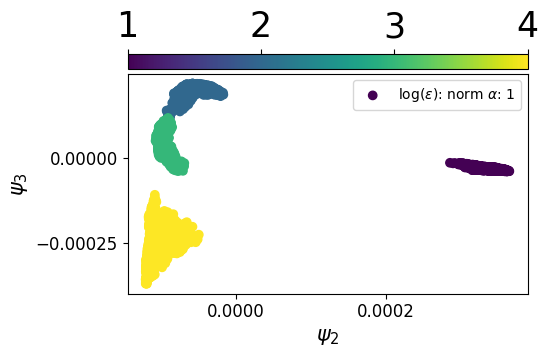

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

__psi=[__psi]

def plot2Dmaps(data, title, nplots_x, nplots_y, dtype, nvecs, lead, colorMap, cmap, colorlabel, figSuffix=''):
    
    
    print(f"nplots_x:{nplots_x}, nplots_y:{nplots_y}")
    
    if dtype == 'spec':
        fig = plt.figure(figsize = (20,20))
    else:
        fig = plt.figure(figsize = (5,3))
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.4)
    
    count = 0
    for i in range(nplots_x):
        for j in range(nplots_y):
    
            ax = fig.add_subplot(nplots_x,nplots_y,count+1)
        
            label = r'log($\epsilon$): ' + 'norm' + r' $\alpha$: ' + str(np.round(title[count][1],3))
            
            if dtype == 'spec':
                ax.bar(np.arange(len(data[count][lead:nvecs])), data[count][lead:nvecs], color=colorMap,
                      label=label)
                ax.set_xlabel('index', fontsize=15)
                ax.set_ylabel('eval', fontsize=15)
                plt.xticks(np.arange(lead-1, len(data[count][1:nvecs]), step=2), 
                           list(np.arange(lead+1, len(data[count][1:nvecs])+1, step=2)), fontsize=12)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                
            else:
                im = ax.scatter(data[count][0:,lead], data[count][0:,lead+1], c=colorMap, cmap=cmap, label=label)
                ax.set_xlabel('$\psi$$_{'+str(lead+1)+'}$', fontsize=15)
                ax.set_ylabel('$\psi$$_{'+str(lead+2)+'}$', fontsize=15)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                if count == 0:
                    
                    divider = make_axes_locatable(ax)
                    cax = divider.append_axes("top", size="7%", pad="2%") #new_vertical("top", pad='5%')
                    fig.add_axes(cax)
                    cbar = fig.colorbar(im, cax=cax, orientation="horizontal",
                                        ticks=list(np.arange(1,len(colorlabel)+1)))
                    #cbar.set_ticklabels(colorlabel, fontsize=12)
                    cax.xaxis.set_ticks_position("top")
                
            ax.legend(fontsize=10)
            #fig.tight_layout(pad=.5)
            #fig.savefig(figSuffix, dpi=100)

            count += 1
    return

figname_offset=0
select_grid_start = 0
select_grid_end = 1
rows_plot = 1 #9
cols_plot = 1
lead=1
nvecs=20


#lcmap = (mpl.colors.ListedColormap(['deepskyblue', 'blue', 'green', 'orange']) #'red', 'black'
#        .with_extremes(over='0.25', under='0.75'))
lcmap = 'viridis'

colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3, np.ones(2450)*4]
nframes = 9800/4
#colors = [np.arange(nframes)*1, np.arange(nframes, 2*nframes)*1, np.arange(nframes*2, 3*nframes)*1, np.arange(nframes*3, 4*nframes)*1]
#colors = list(np.concatenate((colors[0], colors[1], colors[3], colors[3])))
colors = colors[0:]
plot2Dmaps(__psi[select_grid_start:select_grid_end], _ea[select_grid_start:select_grid_end], rows_plot, cols_plot, '', nvecs=nvecs+lead, 
           lead=lead, colorMap=colors, cmap=lcmap, colorlabel=['Bent', 'Int1', 'Int2', 'Open'],
           figSuffix='dmaps_leading_e_alpha' + 'k_norm' + '_' + str(_ea[0][1]) + '.png' )



In [328]:
x1 = np.arange(1,10.0).reshape((3, 3))
print(x1)


[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]


In [329]:
x1/x1

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])